## Model 1 Ontology PCA - Biotechnology & Pharmaceutical Industry<br>
company-year-industry where we get the top metrics categories for the given industry based on company and year relation from GraphDB.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.cluster import AgglomerativeClustering


In [13]:

sparql = SPARQLWrapper("http://MacBookAir.modem:7200/repositories/ESG_DataSet1")
# Define the SPARQL query to extract ESG observations.


In [15]:

# Set SPARQL query
sparql.setQuery("""
PREFIX ex: <http://example.org/esg#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?company ?year ?metric ?value ?category ?pillar ?industry
WHERE {
  ?obs a ex:ESGObservation ;
       ex:hasCompany ?company ;
       ex:hasYear ?year ;
       ex:hasMetric ?metric ;
       ex:hasValue ?value .
  ?metric ex:hasCategory ?category ;
          ex:hasPillar ?pillar ;
          ex:belongsToIndustry ?industry .
  FILTER regex(str(?industry), "biotechnology_pharmaceuticals", "i")
}
ORDER BY ?company ?metric ?year
""")


sparql.setReturnFormat(JSON)
results = sparql.query().convert()
# Convert SPARQL results to a flat list of records


In [16]:

records = []
for result in results["results"]["bindings"]:
    company = result["company"]["value"].split("#")[-1]  # extract local name
    year = result["year"]["value"]
    metric = result["metric"]["value"].split("#")[-1]    # extract local name
    value = float(result["value"]["value"])
    category = result["category"]["value"].split("#")[-1]
    industry = result["industry"]["value"].split("#")[-1]
    pillar = result["pillar"]["value"].split("#")[-1]    # extract local name for pillar
    records.append({
        "company": company,
        "year": year,
        "metric": metric,
        "value": value,
        "category": category,
        "industry": industry,
        "pillar": pillar  
    })
# Create DataFrame from records
df_raw_bp = pd.DataFrame(records)

# Create a unique identifier for each entity (company_year)
df_raw_bp["entity"] = df_raw_bp["company"] + "_" + df_raw_bp["year"]

# Pivot: rows = entity, columns = metric, values = value
df_pivot_bp = df_raw_bp.pivot_table(index="entity", columns="metric", values="value")
# Replace 0 values with NaN (assuming zeros indicate missing/unreported values)
df_pivot_bp = df_pivot_bp.replace(0, np.nan)

# # Drop columns with more than 90% missing values
# threshold = 0.8
# cols_to_keep = [col for col in df_pivot_bp.columns if df_pivot_bp[col].isnull().mean() <= threshold]
# df_pivot_bp_filtered = df_pivot_bp[cols_to_keep]

# Compute the median for each metric (column), ignoring NaN
median_values = df_pivot_bp.median()



In [41]:

# Impute the missing values with the corresponding column medians
df_pivot_bp_imputed = df_pivot_bp.fillna(median_values)
# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot_bp_imputed)

# Step 2: Print shape to understand limits
n_samples, n_features = scaled_data.shape
print(f"PCA Input Shape: {n_samples} samples × {n_features} features")

# Step 3: Auto-adjust n_components to avoid crashing
n_components = 2
if n_components < 2:
    raise ValueError(f" Not enough data for PCA: need at least 2 components, got {n_components}")

# Step 4: Run PCA safely
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)


PCA Input Shape: 6206 samples × 3 features


Explained Variance Ratio per PC: [0.54616999 0.45383001]
Cumulative Explained Variance: [0.54616999 1.        ]


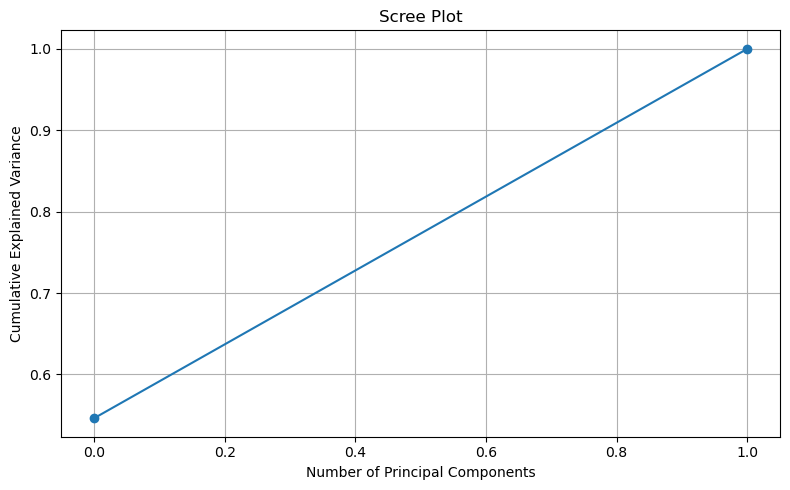

In [42]:

# Step 5: Output explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio per PC:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance))
df_pivot_bp_imputed.to_csv("pca_input_debug.csv")
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


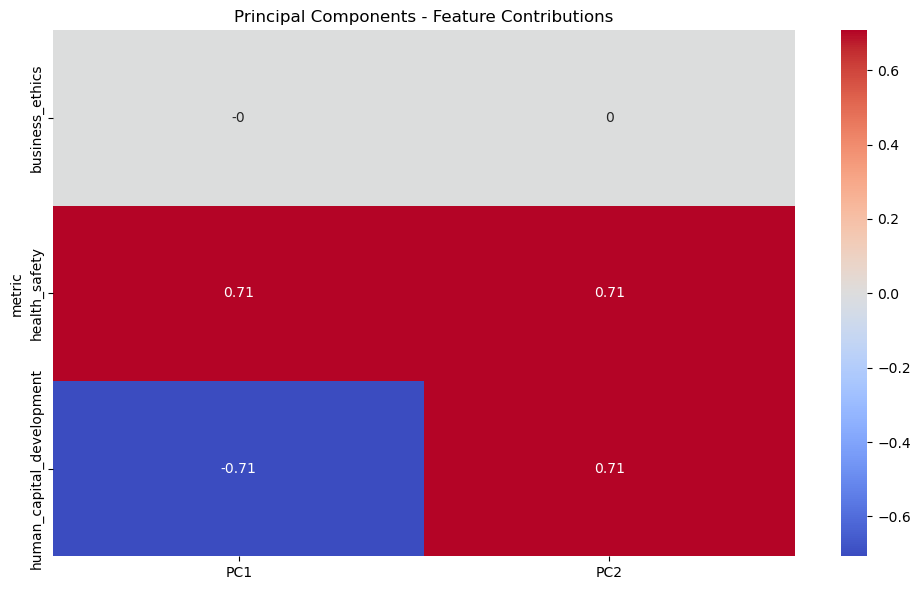

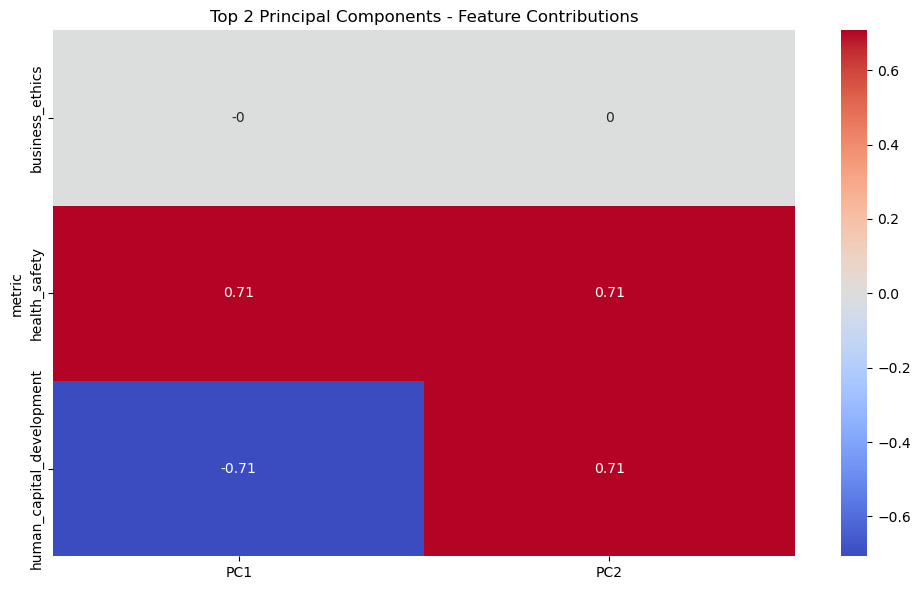

In [43]:

# Loadings indicate how much each original ESG metric contributes to each PC.
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pivot_bp_imputed.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap="coolwarm", center=0)
plt.title("Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm", center=0)
plt.title("Top 2 Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()


In [44]:
# First, create a unique mapping of metric to pillar from raw dataset
df_metric_pillar = df_raw_bp[['metric', 'pillar']].drop_duplicates()

# Merge the PCA loadings with the pillar info
loadings_with_pillar = (
    loadings
    .reset_index()                      # metric names are in index
    .rename(columns={'index': 'metric'})
    .merge(df_metric_pillar, on='metric', how='left')
)

In [45]:

# These scores are the representation of each observation in the PC space.
pca_scores = pd.DataFrame(
    pca_result,
    columns=[f"PC{i+1}" for i in range(pca_result.shape[1])]
)
pca_scores["entity"] = df_pivot_bp_imputed.index


In [46]:

# Determine available principal components from loadings
available_pcs = [col for col in loadings.columns if col.startswith("PC")]

for pc in available_pcs:
    pc_sorted = loadings_with_pillar[['metric', 'pillar', pc]].copy()
    pc_sorted["loading_abs"] = pc_sorted[pc].abs()
    pc_sorted = pc_sorted.sort_values("loading_abs", ascending=False)
    
    print(f"\nTop metrics driving {pc}:")
    print(pc_sorted.head(10))
    
    print(f"\nTop metrics driving {pc}:")
    print(pc_sorted.head(10))
# Create a PCA biplot for PC1 and PC2
plt.figure(figsize=(10, 8))



Top metrics driving PC1:
                      metric         pillar       PC1  loading_abs
1              health_safety         s_risk  0.707107     0.707107
2  human_capital_development         s_risk -0.707107     0.707107
3  human_capital_development  s_opportunity -0.707107     0.707107
4  human_capital_development         g_risk -0.707107     0.707107
0            business_ethics         s_risk -0.000000     0.000000

Top metrics driving PC1:
                      metric         pillar       PC1  loading_abs
1              health_safety         s_risk  0.707107     0.707107
2  human_capital_development         s_risk -0.707107     0.707107
3  human_capital_development  s_opportunity -0.707107     0.707107
4  human_capital_development         g_risk -0.707107     0.707107
0            business_ethics         s_risk -0.000000     0.000000

Top metrics driving PC2:
                      metric         pillar       PC2  loading_abs
2  human_capital_development         s_risk  0.7071

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

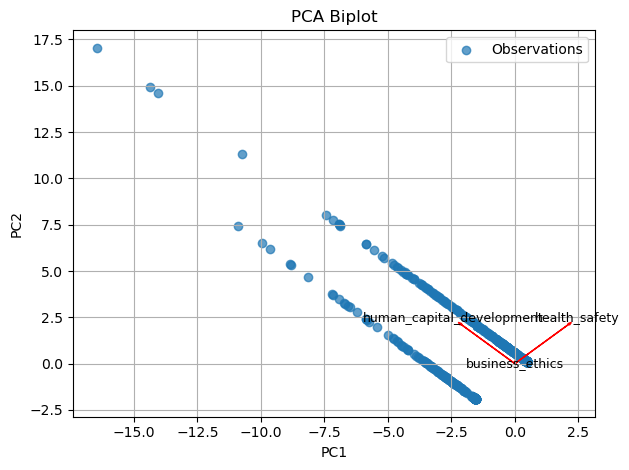

In [47]:

# Plot the PCA scores (observations)
plt.scatter(pca_scores["PC1"], pca_scores["PC2"], alpha=0.7, label="Observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

# Scale factor for arrows (to make the vectors visible in the score space)
# You might need to adjust this scaling factor depending on your data.
arrow_scale = 3

# Plot the loadings as arrows
for i, metric in enumerate(loadings.index):
    
    # Get the loadings for PC1 and PC2
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    
    # Plot an arrow for each metric
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    
    # Annotate the arrow with the metric name
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [48]:

# Use Agglomerative Clustering on the first two principal components
agg_clust = AgglomerativeClustering(n_clusters=3)
clusters = agg_clust.fit_predict(pca_scores[["PC1", "PC2"]])
pca_scores["cluster"] = clusters


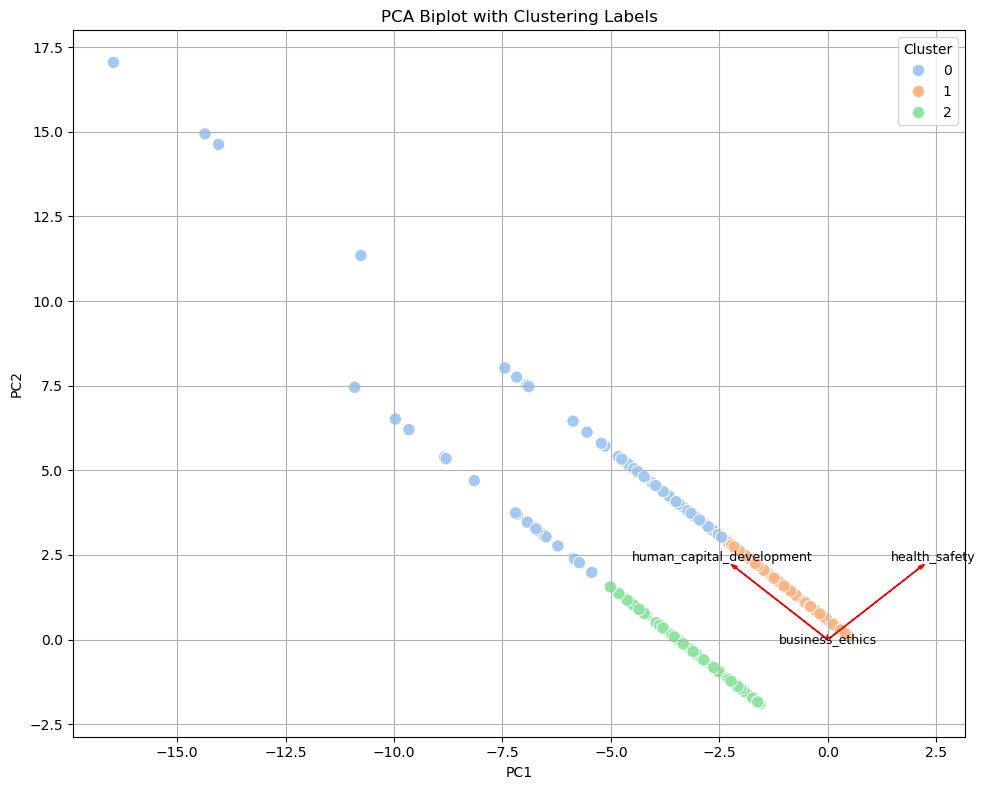

In [49]:

# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))

# Plot the observations with cluster colors
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_scores, palette="pastel", s=80)

# Define an arrow scale factor (adjust as needed)
arrow_scale = 3

# Plot the loadings as arrows
for metric in loadings.index:
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.title("PCA Biplot with Clustering Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:

# Identify which columns are the PC loadings
pc_cols = [col for col in loadings_with_pillar.columns if col.startswith("PC")]


# Melt the loadings DataFrame so that each row contains one metric’s loading for a given PC
df_melted = loadings_with_pillar.melt(
    id_vars=["metric", "pillar"],      # Keep these columns fixed
    value_vars=pc_cols,                # Unpivot the PC columns
    var_name="PC",                     # New column indicating which PC
    value_name="loading"               # New column with the loading value
)

# Create a column for the absolute loading for ranking purposes
df_melted["abs_loading"] = df_melted["loading"].abs()

# For each PC, select the top N metrics by absolute loading
top_n = 10
top_metrics = df_melted.groupby("PC", group_keys=False).apply(lambda g: g.nlargest(top_n, "abs_loading")).reset_index(drop=True)

top_metrics = top_metrics[["PC", "metric", "pillar", "abs_loading"]]

print("Top metrics driving each PC:")
print(top_metrics)
# Sort the results by PC, then by pillar (alphabetically), then by absolute loading (descending)
top_metrics = top_metrics.sort_values(by=["PC", "pillar", "abs_loading"], ascending=[True, True, False])

print("Top metrics driving each PC:")
print(top_metrics)

Top metrics driving each PC:
    PC                     metric         pillar  abs_loading
0  PC1              health_safety         s_risk     0.707107
1  PC1  human_capital_development         s_risk     0.707107
2  PC1  human_capital_development  s_opportunity     0.707107
3  PC1  human_capital_development         g_risk     0.707107
4  PC1            business_ethics         s_risk     0.000000
5  PC2  human_capital_development         s_risk     0.707107
6  PC2  human_capital_development  s_opportunity     0.707107
7  PC2  human_capital_development         g_risk     0.707107
8  PC2              health_safety         s_risk     0.707107
9  PC2            business_ethics         s_risk     0.000000
Top metrics driving each PC:
    PC                     metric         pillar  abs_loading
3  PC1  human_capital_development         g_risk     0.707107
2  PC1  human_capital_development  s_opportunity     0.707107
0  PC1              health_safety         s_risk     0.707107
1  PC1  huma

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_15421/2842750728.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_metrics = df_melted.groupby("PC", group_keys=False).apply(lambda g: g.nlargest(top_n, "abs_loading")).reset_index(drop=True)
